In [2]:
# !pip3 install SimpleITK
# pip install numpy
# !pip install scipy
# !pip3 install matplotlib

In [3]:
# https://github.com/SimpleITK/TUTORIAL/blob/main/06_advanced_registration.ipynb

# inne:
# https://github.com/InsightSoftwareConsortium/SimpleITK-Notebooks/blob/master/Python/56_VH_Registration1.ipynb
# https://github.com/InsightSoftwareConsortium/SimpleITK-Notebooks/blob/master/Python/60_Registration_Introduction.ipynb
# https://github.com/InsightSoftwareConsortium/SimpleITK-Notebooks/blob/master/Python/61_Registration_Introduction_Continued.ipynb
# https://github.com/InsightSoftwareConsortium/SimpleITK-Notebooks/blob/master/Python/62_Registration_Tuning.ipynb
# https://github.com/InsightSoftwareConsortium/SimpleITK-Notebooks/blob/master/Python/63_Registration_Initialization.ipynb
# https://github.com/InsightSoftwareConsortium/SimpleITK-Notebooks/blob/master/Python/64_Registration_Memory_Time_Tradeoff.ipynb
# https://github.com/InsightSoftwareConsortium/SimpleITK-Notebooks/blob/master/Python/65_Registration_FFD.ipynb
# https://github.com/InsightSoftwareConsortium/SimpleITK-Notebooks/blob/master/Python/66_Registration_Demons.ipynb
# https://github.com/InsightSoftwareConsortium/SimpleITK-Notebooks/blob/master/Python/67_Registration_Semiautomatic_Homework.ipynb
# https://github.com/InsightSoftwareConsortium/SimpleITK-Notebooks/blob/master/Python/68_Registration_Errors.ipynb

import SimpleITK as sitk
import numpy as np
import scipy.ndimage as nd
import matplotlib.pyplot as plt
import napari

In [4]:
### Initial Exploration ###
moving_mask_path = 'initial_mask.nii.gz'
fixed_mask_path  = 'final_mask.nii.gz'


moving_mask = sitk.GetArrayFromImage(sitk.ReadImage(moving_mask_path)).swapaxes(0, 1).swapaxes(1, 2).astype(np.float32)
fixed_mask =  sitk.GetArrayFromImage(sitk.ReadImage(fixed_mask_path)).swapaxes(0, 1).swapaxes(1, 2).astype(np.float32)

print(f"Moving mask shape: {moving_mask.shape}")
print(f"Fixed mask shape: {fixed_mask.shape}")


moving_unique, moving_counts = np.unique(moving_mask, return_counts=True)
fixed_unique, fixed_counts   = np.unique(fixed_mask, return_counts=True)

print(f"Moving unique / counts: {moving_unique, moving_counts}")
print(f"Fixed unique / counts: {fixed_unique, fixed_counts}")

Moving mask shape: (512, 512, 145)
Fixed mask shape: (512, 512, 145)
Moving unique / counts: (array([0., 1., 2., 3., 4.], dtype=float32), array([29946679,  7339239,   617866,    92766,    14330]))
Fixed unique / counts: (array([0., 1., 2., 3., 4.], dtype=float32), array([30418200,  6934504,   608200,    35646,    14330]))


In [5]:
print(moving_mask.shape[2])
print(moving_mask.shape[2] // 2)

145
72


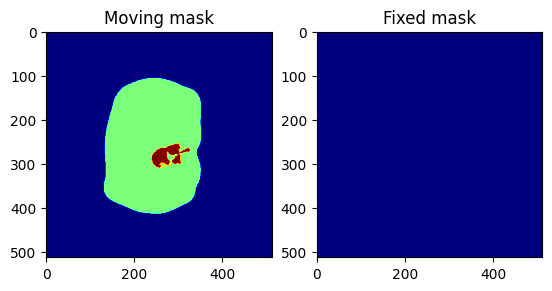

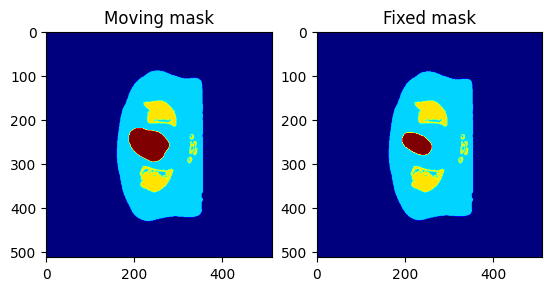

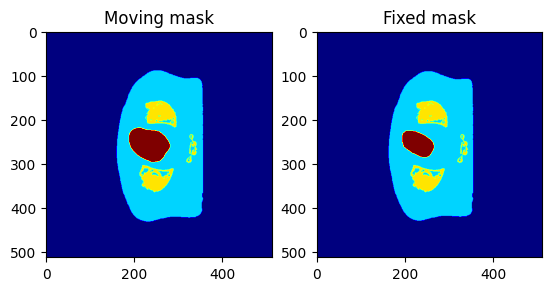

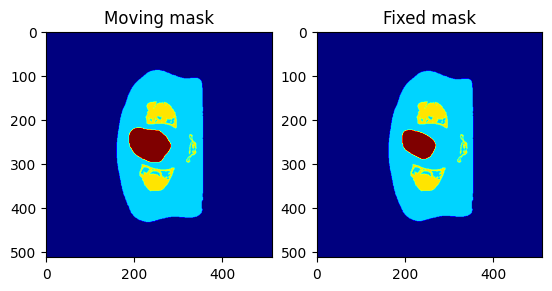

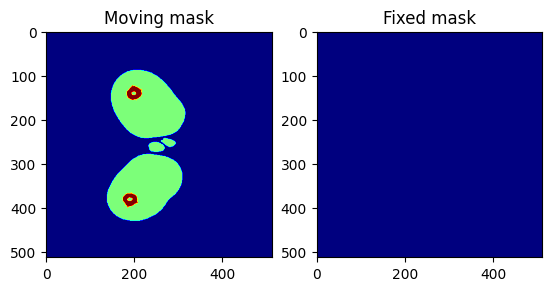

In [6]:
plt.figure(dpi=100)
plt.subplot(1, 2, 1)
plt.imshow(moving_mask[:, :, 0], cmap='jet')
plt.title("Moving mask")
plt.subplot(1, 2, 2)
plt.imshow(fixed_mask[:, :, 0], cmap='jet')
plt.title("Fixed mask")
plt.show()

plt.figure(dpi=100)
plt.subplot(1, 2, 1)
plt.imshow(moving_mask[:, :, 71], cmap='jet')
plt.title("Moving mask")
plt.subplot(1, 2, 2)
plt.imshow(fixed_mask[:, :, 71], cmap='jet')
plt.title("Fixed mask")
plt.show()

z_slice = moving_mask.shape[2] // 2

plt.figure(dpi=100)
plt.subplot(1, 2, 1)
plt.imshow(moving_mask[:, :, z_slice], cmap='jet')
plt.title("Moving mask")
plt.subplot(1, 2, 2)
plt.imshow(fixed_mask[:, :, z_slice], cmap='jet')
plt.title("Fixed mask")
plt.show()

z_slice = moving_mask.shape[2] // 2
plt.figure(dpi=100)
plt.subplot(1, 2, 1)
plt.imshow(moving_mask[:, :, 73], cmap='jet')
plt.title("Moving mask")
plt.subplot(1, 2, 2)
plt.imshow(fixed_mask[:, :, 73], cmap='jet')
plt.title("Fixed mask")
plt.show()

plt.figure(dpi=100)
plt.subplot(1, 2, 1)
plt.imshow(moving_mask[:, :, 144], cmap='jet')
plt.title("Moving mask")
plt.subplot(1, 2, 2)
plt.imshow(fixed_mask[:, :, 144], cmap='jet')
plt.title("Fixed mask")
plt.show()

In [7]:
### Define Registration Method ###
def smooth_and_resample(image, shrink_factor, smoothing_sigma):
    """
    Args:
        image: The image we want to resample.
        shrink_factor: A number greater than one, such that the new image's size is original_size/shrink_factor.
        smoothing_sigma: Sigma for Gaussian smoothing, this is in physical (image spacing) units, not pixels.
    Return:
        Image which is a result of smoothing the input and then resampling it using the given sigma and shrink factor.
    """
    smoothed_image = sitk.SmoothingRecursiveGaussian(image, smoothing_sigma)
    
    original_spacing = image.GetSpacing()
    original_size    = image.GetSize()

    new_size    = [int(sz/float(shrink_factor) + 0.5) for sz in original_size]
    new_spacing = [((original_sz-1)*original_spc)/(new_sz-1) for original_sz, original_spc, new_sz in zip(original_size, original_spacing, new_size)]
    
    return sitk.Resample(
        smoothed_image, 
        new_size, 
        sitk.Transform(), 
        sitk.sitkLinear, 
        image.GetOrigin(),
        new_spacing, 
        image.GetDirection(), 
        0.0, 
        image.GetPixelID()
    )
   
def multiscale_demons(
    registration_algorithm,
    fixed_image, 
    moving_image, 
    initial_transform = None, 
    shrink_factors=None, 
    smoothing_sigmas=None
):
    """
    Run the given registration algorithm in a multiscale fashion. The original scale should not be given as input as the
    original images are implicitly incorporated as the base of the pyramid.
    Args:
        registration_algorithm: Any registration algorithm that has an Execute(fixed_image, moving_image, displacement_field_image)
                                method.
        fixed_image:  Resulting transformation maps points from this image's spatial domain to the moving image spatial domain.

        moving_image: Resulting transformation maps points from the fixed_image's spatial domain to this image's spatial domain.

        initial_transform: Any SimpleITK transform, used to initialize the displacement field.

        shrink_factors: Shrink factors relative to the original image's size.
        
        smoothing_sigmas: Amount of smoothing which is done prior to resmapling the image using the given shrink factor. These
                          are in physical (image spacing) units.
    Returns: 
        SimpleITK.DisplacementFieldTransform
    """
    # Create image pyramid.
    fixed_images  = [fixed_image]
    moving_images = [moving_image]

    if shrink_factors:
        for shrink_factor, smoothing_sigma in reversed(list(zip(shrink_factors, smoothing_sigmas))):
            fixed_images.append( smooth_and_resample(fixed_images[0], shrink_factor, smoothing_sigma))
            moving_images.append(smooth_and_resample(moving_images[0],shrink_factor, smoothing_sigma))
    
    # Create initial displacement field at lowest resolution. 
    # Currently, the pixel type is required to be sitkVectorFloat64 because of a constraint imposed by the Demons filters.
    if initial_transform:
        initial_displacement_field = sitk.TransformToDisplacementField(
            initial_transform, 
            sitk.sitkVectorFloat64,
            fixed_images[-1].GetSize(),
            fixed_images[-1].GetOrigin(),
            fixed_images[-1].GetSpacing(),
            fixed_images[-1].GetDirection()
        )
    else:
        initial_displacement_field = sitk.Image(
            fixed_images[-1].GetWidth(), 
            fixed_images[-1].GetHeight(),
            fixed_images[-1].GetDepth(),
            sitk.sitkVectorFloat64
        )
        initial_displacement_field.CopyInformation(fixed_images[-1])
 
    # Run the registration.            
    initial_displacement_field = registration_algorithm.Execute(
        fixed_images[-1], 
        moving_images[-1], 
        initial_displacement_field
    )

    # Start at the top of the pyramid and work our way down.    
    for f_image, m_image in reversed(list(zip(fixed_images[0:-1], moving_images[0:-1]))):
        initial_displacement_field = sitk.Resample (initial_displacement_field, f_image)
        initial_displacement_field = registration_algorithm.Execute(f_image, m_image, initial_displacement_field)
    
    return sitk.DisplacementFieldTransform(initial_displacement_field)

In [8]:
### Run Registration ###
moving_img = sitk.GetImageFromArray(moving_mask)
fixed_img  = sitk.GetImageFromArray(fixed_mask)

# Select a Demons filter and configure it.
demons_filter =  sitk.DiffeomorphicDemonsRegistrationFilter()


demons_filter.SetNumberOfIterations(60)
# Regularization (update field - viscous, total field - elastic).
demons_filter.SetSmoothDisplacementField(True)
demons_filter.SetStandardDeviations(0.6)

# create initial transform
initial_transform = sitk.CenteredTransformInitializer(
    fixed_img, 
    moving_img, 
    sitk.Euler3DTransform(), 
    sitk.CenteredTransformInitializerFilter.GEOMETRY
)


# Run the registration.
tfm = multiscale_demons(
    registration_algorithm=demons_filter, 

    fixed_image = fixed_img,
    moving_image = moving_img,

    initial_transform = initial_transform,
    shrink_factors = [16, 8, 4, 2],
    smoothing_sigmas = [16, 8, 4, 2]
)

print(f"Calculated transform: {tfm}")

Calculated transform: itk::simple::DisplacementFieldTransform
 DisplacementFieldTransform (0x14c1040c0)
   RTTI typeinfo:   itk::DisplacementFieldTransform<double, 3u>
   Reference Count: 1
   Modified Time: 37220
   Debug: Off
   Object Name: 
   Observers: 
     none
   DisplacementField: 
     Image (0x10e1ee9e0)
       RTTI typeinfo:   itk::Image<itk::Vector<double, 3u>, 3u>
       Reference Count: 3
       Modified Time: 37216
       Debug: Off
       Object Name: 
       Observers: 
         none
       Source: (none)
       Source output name: (none)
       Release Data: Off
       Data Released: False
       Global Release Data: Off
       PipelineMTime: 0
       UpdateMTime: 0
       RealTimeStamp: 0 seconds 
       LargestPossibleRegion: 
         Dimension: 3
         Index: [0, 0, 0]
         Size: [145, 512, 512]
       BufferedRegion: 
         Dimension: 3
         Index: [0, 0, 0]
         Size: [145, 512, 512]
       RequestedRegion: 
         Dimension: 3
         Ind

In [9]:
### Helper Dice ###
def dice(input1 : np.ndarray, input2 : np.ndarray):
    
    input1 = np.atleast_1d(input1.astype(bool))
    input2 = np.atleast_1d(input2.astype(bool))
    
    intersection = np.count_nonzero(input1 & input2)
    
    size_i1 = np.count_nonzero(input1)
    size_i2 = np.count_nonzero(input2)
    
    try:
        dc = 2. * intersection / float(size_i1 + size_i2)
    except ZeroDivisionError:
        dc = 0.0
    return dc

In [10]:
### Get Displacement Field & Warp The Images ###
displacement_field = sitk.GetArrayFromImage(tfm.GetDisplacementField())
print(f"Displacement field shape: {displacement_field.shape}")

# Initial Dice for each mask
for _, value in enumerate(moving_unique):
    print(f"Initial Dice for class: {int(value)}: {dice(moving_mask == value, fixed_mask == value)}")

# Image warping
y_size, x_size, z_size, _ = displacement_field.shape    

grid_x, grid_y, grid_z = np.meshgrid(np.arange(x_size), np.arange(y_size), np.arange(z_size), indexing='ij')

warped_moving_mask = nd.map_coordinates(
    moving_mask, 
    [
        grid_x + displacement_field[:, :, :, 2], 
        grid_y + displacement_field[:, :, :, 1], 
        grid_z + displacement_field[:, :, :, 0]], 
    order=0
)

print(f"Warped moving mask shape: {warped_moving_mask.shape}")

# Registered Dice for each mask
for _, value in enumerate(moving_unique):
    print(f"Warped Dice for class: {int(value)}: {dice(warped_moving_mask == value, fixed_mask == value)}")

Displacement field shape: (512, 512, 145, 3)
Initial Dice for class: 0: 0.9921888189322802
Initial Dice for class: 1: 0.9627843236353631
Initial Dice for class: 2: 0.992070573688529
Initial Dice for class: 3: 0.5551817587141389
Initial Dice for class: 4: 0.43817166782972783
Warped moving mask shape: (512, 512, 145)
Warped Dice for class: 0: 0.988538876843249
Warped Dice for class: 1: 0.9464474267105717
Warped Dice for class: 2: 0.968491996348449
Warped Dice for class: 3: 0.9689437578190517
Warped Dice for class: 4: 0.9441712267091501


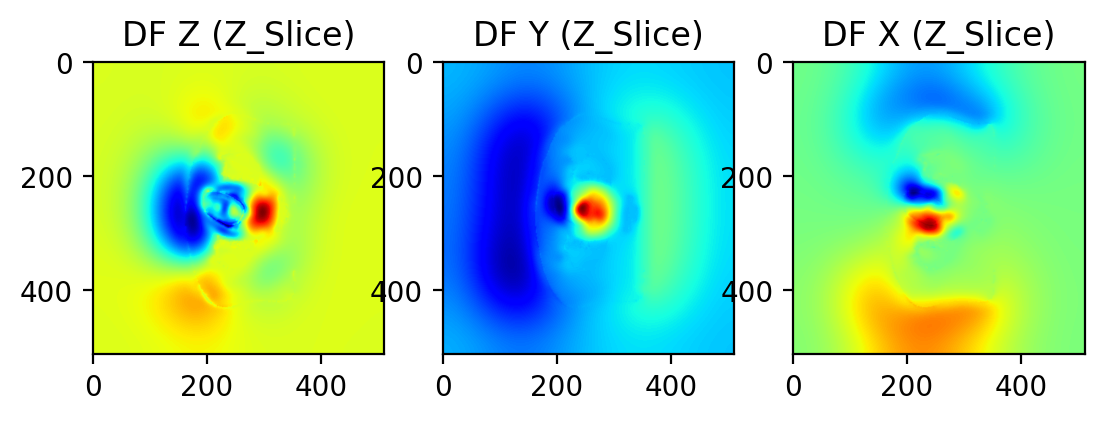

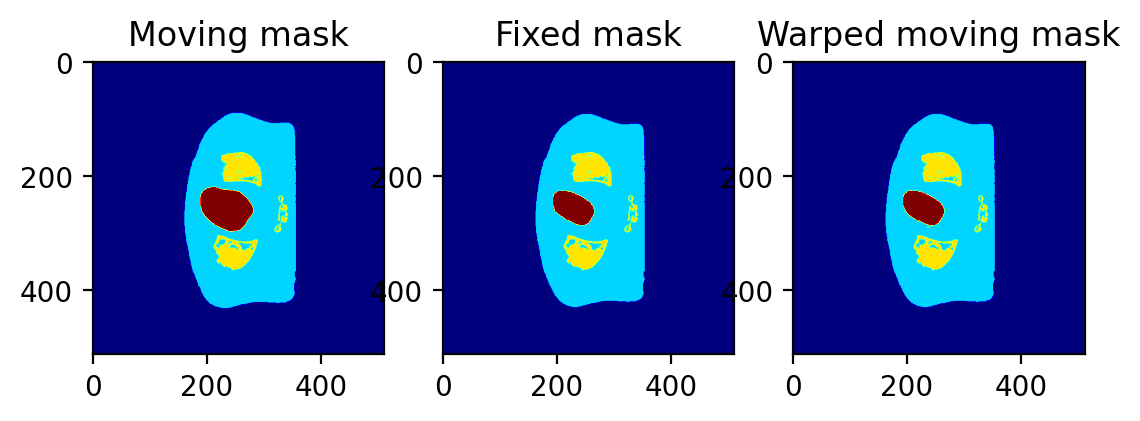

In [11]:
# DF Visualization    
z_slice = moving_mask.shape[2] // 2 

plt.figure(dpi=200)

plt.subplot(1, 3, 1)
plt.imshow(displacement_field[:, :, z_slice, 0], cmap='jet')
plt.title("DF Z (Z_Slice)")

plt.subplot(1, 3, 2)
plt.imshow(displacement_field[:, :, z_slice, 1], cmap='jet')
plt.title("DF Y (Z_Slice)")

plt.subplot(1, 3, 3)
plt.imshow(displacement_field[:, :, z_slice, 2], cmap='jet')
plt.title("DF X (Z_Slice)")

plt.show()

# Mask Visualization
plt.figure(dpi=200)

plt.subplot(1, 3, 1)
plt.imshow(moving_mask[:, :, z_slice], cmap='jet')
plt.title("Moving mask")

plt.subplot(1, 3, 2)
plt.imshow(fixed_mask[:, :, z_slice], cmap='jet')
plt.title("Fixed mask")

plt.subplot(1, 3, 3)
plt.imshow(warped_moving_mask[:, :, z_slice], cmap='jet')
plt.title("Warped moving mask")

plt.show()

In [12]:
### Check Inverse ###
inv_displacement_field = sitk.GetArrayFromImage(sitk.InvertDisplacementField(tfm.GetDisplacementField()))

y_size, x_size, z_size, _ = inv_displacement_field.shape    
grid_x, grid_y, grid_z    = np.meshgrid(np.arange(x_size), np.arange(y_size), np.arange(z_size), indexing='ij')

rewarped_moving_mask = nd.map_coordinates(
    warped_moving_mask, 
    [
        grid_x + inv_displacement_field[:, :, :, 2], 
        grid_y + inv_displacement_field[:, :, :, 1], 
        grid_z + inv_displacement_field[:, :, :, 0]
    ], order=0
)

print(f"Rewarped moving mask shape: {warped_moving_mask.shape}")

Rewarped moving mask shape: (512, 512, 145)


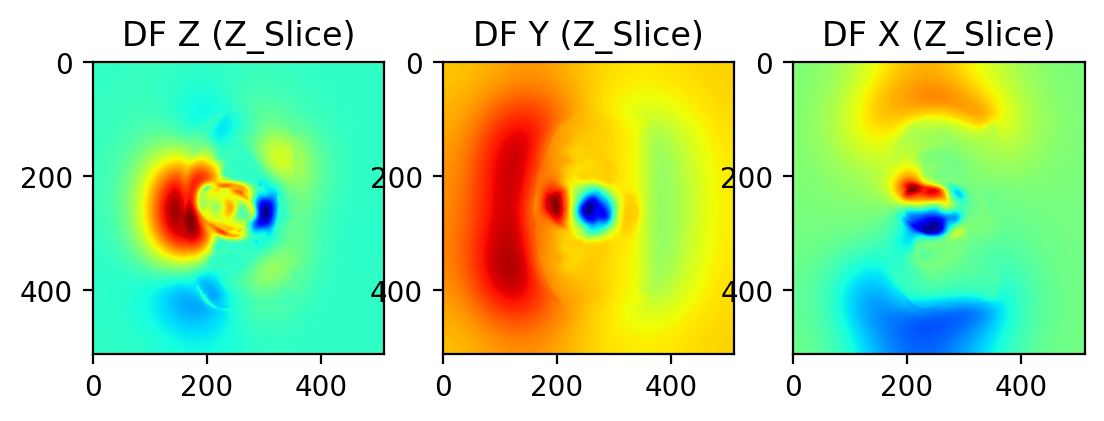

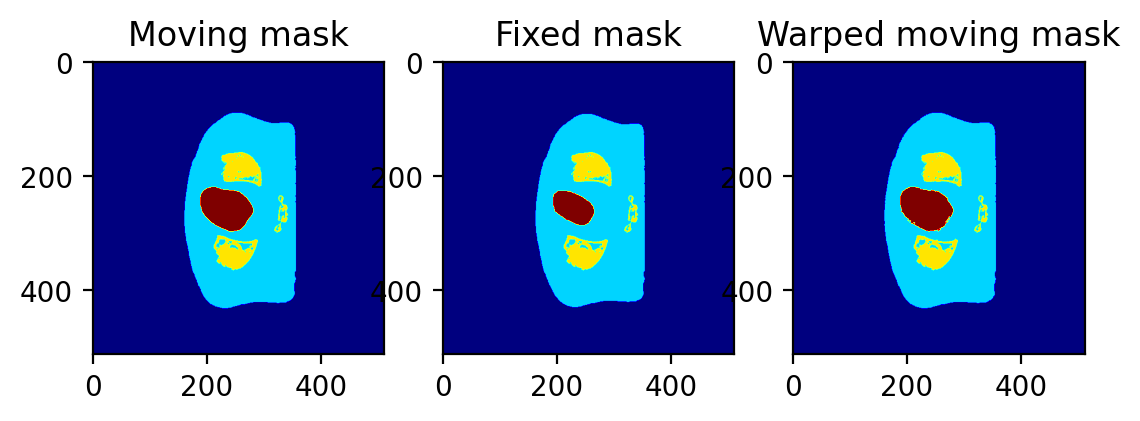

Initial Dice for class: 0: 0.9921888189322802
Initial Dice for class: 1: 0.9627843236353631
Initial Dice for class: 2: 0.992070573688529
Initial Dice for class: 3: 0.5551817587141389
Initial Dice for class: 4: 0.43817166782972783
Rewarped Dice for class: 0: 0.9938073981527401
Rewarped Dice for class: 1: 0.9678048011381345
Rewarped Dice for class: 2: 0.9777232657944023
Rewarped Dice for class: 3: 0.5682493882463594
Rewarped Dice for class: 4: 0.43830942765631525


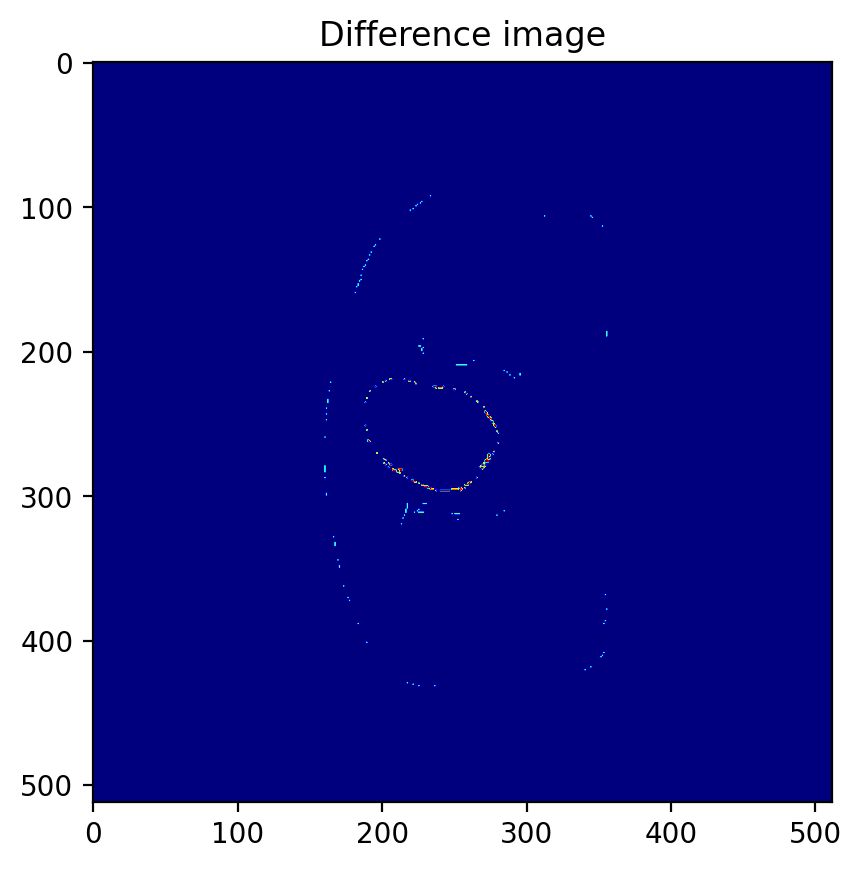

In [13]:
# Inv DF Visualization
z_slice = moving_mask.shape[2] // 2    

plt.figure(dpi=200)

plt.subplot(1, 3, 1)
plt.imshow(
    inv_displacement_field[:, :, z_slice, 0], 
    cmap='jet'
)
plt.title("DF Z (Z_Slice)")

plt.subplot(1, 3, 2)
plt.imshow(
    inv_displacement_field[:, :, z_slice, 1], 
    cmap='jet'
)
plt.title("DF Y (Z_Slice)")

plt.subplot(1, 3, 3)
plt.imshow(
    inv_displacement_field[:, :, z_slice, 2], 
    cmap='jet'
)
plt.title("DF X (Z_Slice)")

plt.show()

# Identity Check
plt.figure(dpi=200)

plt.subplot(1, 3, 1)
plt.imshow(
    moving_mask[:, :, z_slice], 
    cmap='jet'
)
plt.title("Moving mask")

plt.subplot(1, 3, 2)
plt.imshow(
    fixed_mask[:, :, z_slice], 
    cmap='jet'
)
plt.title("Fixed mask")

plt.subplot(1, 3, 3)
plt.imshow(
    rewarped_moving_mask[:, :, z_slice], 
    cmap='jet'
)
plt.title("Warped moving mask")

plt.show()


# Initial Dice for each mask
for _, value in enumerate(moving_unique):
    print(f"Initial Dice for class: {int(value)}: {dice(moving_mask == value, fixed_mask == value)}")
    
# Registered Dice for each mask
for _, value in enumerate(moving_unique):
    print(f"Rewarped Dice for class: {int(value)}: {dice(rewarped_moving_mask == value, fixed_mask == value)}")

# Difference Image    
plt.figure(dpi=200)
plt.imshow(
    np.abs(moving_mask[:, :, z_slice] - rewarped_moving_mask[:, :, z_slice]), 
    cmap='jet'
)
plt.title("Difference image")
plt.show()

In [14]:
### Visualization using the CT ###
moving_image_path = 'ct.nii.gz'

moving_image = sitk.GetArrayFromImage(sitk.ReadImage(moving_image_path)).swapaxes(0, 1).swapaxes(1, 2).astype(np.float32)

# Warp the CT forward and backward
y_size, x_size, z_size, _ = displacement_field.shape    
grid_x, grid_y, grid_z    = np.meshgrid(np.arange(x_size), np.arange(y_size), np.arange(z_size), indexing='ij')

warped_moving_image       = nd.map_coordinates(
    moving_image, 
    [
        grid_x + displacement_field[:, :, :, 2], 
        grid_y + displacement_field[:, :, :, 1], 
        grid_z + displacement_field[:, :, :, 0]], 
    order=3
)
rewarped_moving_image     = nd.map_coordinates(
    warped_moving_image, 
    [
        grid_x + inv_displacement_field[:, :, :, 2], 
        grid_y + inv_displacement_field[:, :, :, 1], 
        grid_z + inv_displacement_field[:, :, :, 0]
    ], 
    order=3
)

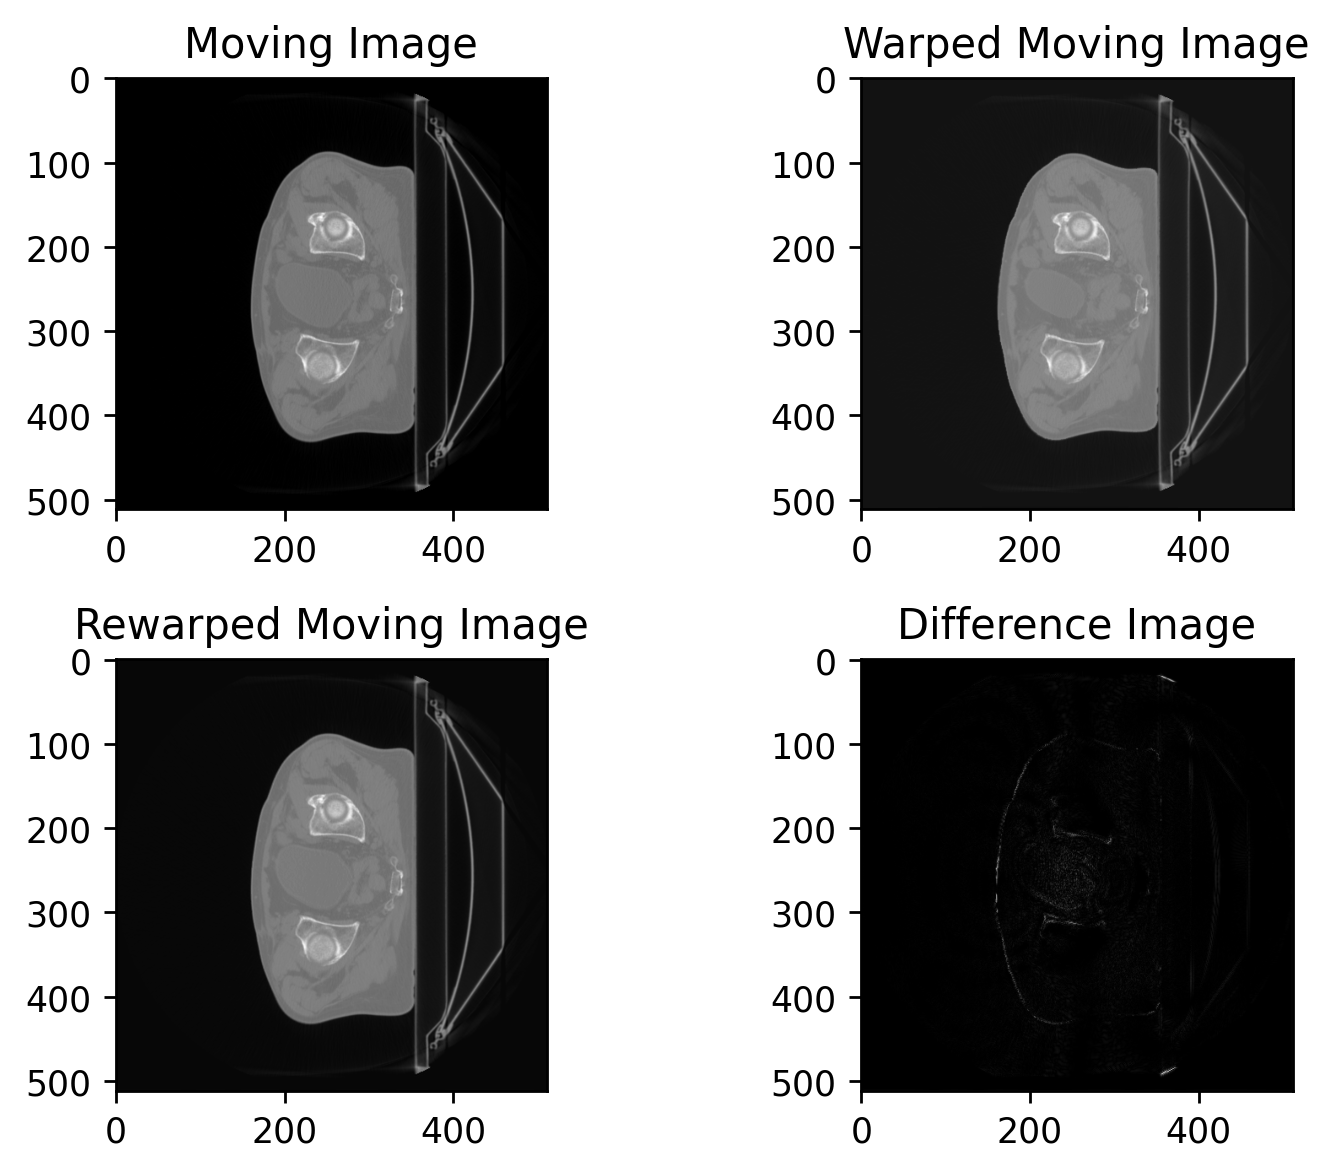

In [15]:
# Visalization - differences mostly due to interpolation error and imperfect inversion
plt.figure(dpi=250)

plt.subplot(2, 2, 1)
plt.imshow(
    moving_image[:, :, z_slice], 
    cmap='gray'
)
plt.title("Moving Image")

plt.subplot(2, 2, 2)
plt.imshow(
    warped_moving_image[:, :, z_slice], 
    cmap='gray'
)
plt.title("Warped Moving Image")

plt.subplot(2, 2, 3)
plt.imshow(
    rewarped_moving_image[:, :, z_slice], 
    cmap='gray'
)
plt.title("Rewarped Moving Image")

plt.subplot(2, 2, 4)
plt.imshow(
    np.abs(rewarped_moving_image[:, :, z_slice] - moving_image[:, :, z_slice]), 
    cmap='gray'
)
plt.title("Difference Image")

plt.tight_layout()
plt.show()

In [16]:
# Calculate landmarks - only for bladder, id "3" in the mask image

from skimage.measure import marching_cubes

dum_mask = np.copy(fixed_mask)
dum_mask[dum_mask!=3] = 0   #bladder
dum_mask[dum_mask!=0] = 1

landmarks,_,_,_ = marching_cubes(dum_mask)

print(len(landmarks))

12576


In [21]:
# Check if the landmarks from a fixed image are indeed located on the surface of bladder in warped moving image
# it should be the case if registration has done a good job

locs = tuple(
    [
        [
            int(l[0]) for l in landmarks
        ],
        [
            int(l[1]) for l in landmarks
        ],
        [
            int(l[2]) for l in landmarks
        ]
    ]
)

dum_warp       = np.copy(warped_moving_image)
dum_warp[locs] = np.max(warped_moving_image)/2


viewer =napari.view_image(dum_warp)

In [ ]:
# And now I am projecting landmarks from the fixed image to the moving image, using the invertible registration transform
# then I check if the landmarks are on the structure surface, now in the original image
# it should be the case for an invertible transformation

dum = np.copy(moving_image)

transformed_points = []
for i in range(landmarks.shape[0]):

    point = (int(landmarks[i][2]),int(landmarks[i][1]),int(landmarks[i][0]))

    physLoc = fixed_img.TransformIndexToPhysicalPoint(point)

    res = tfm.TransformPoint(physLoc)
    # the points that shoud be saved
    transformed_points.append(
        (int(res[2]),
         int(res[1]),
         int(res[0]))
    )


locsTrans = tuple(
    [
        [
            int(l[0]) for l in transformed_points
        ],
        [
            int(l[1]) for l in transformed_points
        ],
        [
            int(l[2]) for l in transformed_points
        ]
    ]
)

dum[locsTrans] = np.max(moving_image)/2

viewer =napari.view_image(dum)

2023-12-06 09:45:16.465 Python[12771:6809622] WARNING: Secure coding is automatically enabled for restorable state! However, not on all supported macOS versions of this application. Opt-in to secure coding explicitly by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState:.
